In [1]:
from mesh_library import *

In [2]:
mesh = mesh_gen_uniform_2D_grid(4,4, "triangle")

In [3]:
meshio.write("mesh.msh", mesh, file_format="gmsh22")

In [4]:
mesh.cell_data

{'gmsh:physical': [array([1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4]),
  array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])],
 'gmsh:geometrical': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]}

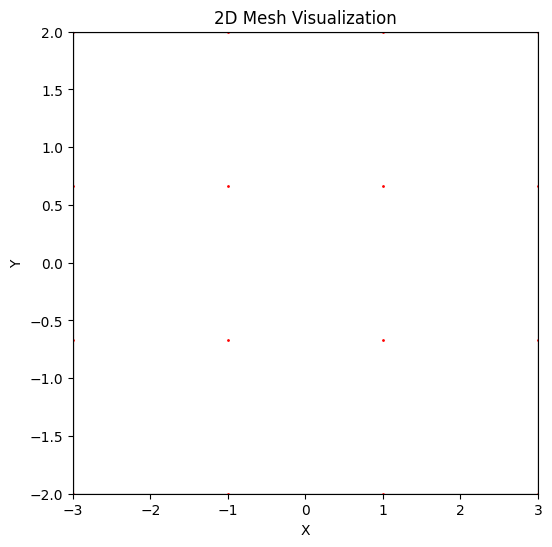

In [5]:
plot_mesh(mesh, "line")

In [6]:
def find_point_on_boundary(point : np.ndarray, rot_mat : np.ndarray, inv_rot_mat : np.ndarray, func : callable = lambda x: 3*x/4) -> np.ndarray:
    vec = np.array([0,0])
    un_rotated_point = point @ inv_rot_mat
    BP = np.array([func(un_rotated_point[0]),0])
    BP = BP@rot_mat
    point_vec = point - BP
    y_sign = np.sign(point[1] - BP[1])
    x_sign = np.sign(point[0] - BP[0])
    b = 0
    c = 0
    if point_vec[1] != 0:
        b = ((2*y_sign - point[1])/point_vec[1])
    if point_vec[0] != 0:
        c = ((3*x_sign - point[0])/point_vec[0])
    if b != 0 and abs(b*point_vec[0] + point[0]) < 3:
        vec = point + point_vec*b
    else:
        vec = point + point_vec*c

    if -3 > vec[0] or vec[0] > 3 or vec[1] < -2 or 2 < vec[1]:
        a = 2
    if np.linalg.norm(vec) == 0:
        raise KeyError("Du tog ikke højde for dette scenarie")
    return vec

In [7]:
def transfinite_line(N : int, p1 : np.ndarray, p2 : np.ndarray, func : callable = lambda x: x**2) -> np.ndarray:
    """
    Generates a line from p1 to p2 with N points, where the spacing between points
    is dictated by the function `func`.
    
    Parameters:
        N (int): Number of points including p1 and p2.
        p1 (np.ndarray): Start point in the plane (2D or 3D).
        p2 (np.ndarray): End point in the plane (2D or 3D).
        func (callable): Function that defines the spacing transformation. 
                         It should take a parameter in [0, 1] and return a value in [0, 1].

    Returns:
        np.ndarray: An array of shape (N, dim) containing the generated points.
    """
    p1, p2 = np.array(p1), np.array(p2)
    assert p1.shape == p2.shape, "p1 and p2 must have the same dimensions"
    
    # Generate uniform parameter values in [0,1]
    s_uniform = np.linspace(0, 1, N+1)
    
    # Apply transformation function
    s_transformed = np.array([func(s) for s in s_uniform])
    
    # Normalize transformed values to stay in [0,1] range
    s_transformed = (s_transformed - s_transformed[0]) / (s_transformed[-1] - s_transformed[0])
    
    # Compute interpolated points
    points = (1 - s_transformed)[:, None] * p1 + s_transformed[:, None] * p2
    
    return points[1:,:]

In [14]:
def NACA_mesh(POA : int, PTA : int, NACA_name : str, gridtype : str = "quad", angle_of_attack : float = 0, func : callable = lambda x : x**2) -> meshio.Mesh:
    try:
        NACA_points = np.loadtxt(f"NACA_{NACA_name}.txt")
    except:
        raise ValueError("The data for this NACA-airfoil is not in the directory")
    # Defining points
    NACA_points = NACA_points[::(200//POA),:]
    NACA_points = NACA_points - np.array([0.5,0])
    POA = NACA_points.shape[0]
    angle_of_attack_rad = angle_of_attack*np.pi/180
    rot_mat = np.array([
        [np.cos(angle_of_attack_rad), -np.sin(angle_of_attack_rad)],
        [np.sin(angle_of_attack_rad), np.cos(angle_of_attack_rad)]
    ])
    inv_rot_mat = np.linalg.inv(rot_mat)
    NACA_points = (NACA_points)@rot_mat
    for i in range(len(NACA_points)):
        p1 = NACA_points[i]
        p2 = find_point_on_boundary(p1,rot_mat, inv_rot_mat)
        NACA_points = np.vstack([NACA_points,transfinite_line(PTA, p1, p2, func)])

    final_points = np.append(NACA_points, np.zeros((NACA_points.shape[0],1)), axis=1)
    # Defining cells
    if gridtype.lower() == "quad":
        amount_of_areas = (POA)*(PTA)
        areas = np.zeros((amount_of_areas,4), dtype=int)
        for j in range(POA):
            for i in range(PTA-1):
                areas[j+i*POA,:] = POA + ((np.array([j*PTA+i, j*PTA+(i+1), (j+1)*PTA+(i+1), (j+1)*PTA+i], dtype=int)) % ((POA)*(PTA+1)-POA))
        for j in range(POA):
            areas[POA*(PTA-1)+ j] = np.array([j, POA + j*PTA, POA + ((j+1)*PTA)%((POA)*(PTA+1)-POA), (j+1)%POA])
    if gridtype.lower() == "triangle":
        amount_of_areas = (POA)*(PTA)*2
        areas = np.zeros((amount_of_areas,3), dtype=int)
        for j in range(POA):
            for i in range(PTA-1):
                areas[(j+i*POA)*2,:] = POA + ((np.array([j*PTA+i, j*PTA+(i+1), (j+1)*PTA+(i+1)], dtype=int)) % ((POA)*(PTA+1)-POA))
                areas[(j+i*POA)*2+1,:] = POA + ((np.array([j*PTA+i, (j+1)*PTA+(i+1), (j+1)*PTA+i], dtype=int)) % ((POA)*(PTA+1)-POA))
        for j in range(POA):
            areas[(POA*(PTA-1)+ j)*2] = np.array([j, POA + j*PTA, POA + ((j+1)*PTA)%((POA)*(PTA+1)-POA)])
            areas[(POA*(PTA-1)+ j)*2+1] = np.array([j, POA + ((j+1)*PTA)%((POA)*(PTA+1)-POA), (j+1)%POA])
    
    # Defining boundaries
    ones = np.where(NACA_points[:,0] == -3)[0]
    nr_ones = len(ones)
    twos = np.where(NACA_points[:,0] == 3)[0]
    nr_twos = len(twos)
    threes = np.where(NACA_points[:,1] == -2)[0]
    nr_threes = len(threes)
    fours = np.where(NACA_points[:,1] == 2)[0]
    nr_fours = len(fours)
    fives = np.arange(POA)
    nr_fives = len(fives)
    lines = np.zeros((nr_fives + nr_ones + nr_twos + nr_threes + nr_fours,2), dtype=int)
    for i in range(nr_ones-1):
        lines[i] = np.array([ones[i],ones[i+1]], dtype=int)
    for i in range(nr_twos-1):
        lines[nr_ones-1 + i] = np.array([twos[i],twos[i+1]], dtype=int)
    for i in range(nr_threes-1):
        lines[nr_ones + nr_twos - 2 + i] = np.array([threes[i],threes[i+1]], dtype=int)
    for i in range(nr_fours-1):
        lines[nr_ones + nr_twos + nr_threes - 3 + i] = np.array([fours[i],fours[i+1]], dtype=int)
    for i in range(nr_fives):
        lines[nr_ones + nr_twos + nr_threes + nr_fours - 4 + i] = np.array([fives[i],fives[(i+1)%nr_fives]], dtype=int)
    lines[-4] = np.array([ones[np.argmin(NACA_points[ones][:,1])], threes[np.argmin(NACA_points[threes][:,0])]])
    lines[-3] = np.array([threes[np.argmax(NACA_points[threes][:,0])], twos[np.argmin(NACA_points[twos][:,1])]])
    lines[-2] = np.array([twos[np.argmax(NACA_points[twos][:,1])], fours[np.argmax(NACA_points[fours][:,0])]])
    lines[-1] = np.array([fours[np.argmin(NACA_points[fours][:,0])], ones[np.argmax(NACA_points[ones][:,1])]])
    
    cells = [("line",lines),(gridtype, areas)]
    mesh = meshio.Mesh(points=NACA_points, cells=cells)
    mesh.cell_data["gmsh:physical"] = [
        np.hstack((np.repeat(1,nr_ones-1), np.repeat(2,nr_twos-1), np.repeat(3,nr_threes-1),np.repeat(4,nr_fours-1), np.repeat(5,POA), np.repeat(1,2), np.repeat(2,2))),
        np.repeat(6,amount_of_areas)
    ]
    mesh = add_dummy_geometrical_data(mesh)
    mesh.points = np.array(mesh.points, dtype=np.float64)
    return mesh
    

    return meshio.Mesh(points=final_points, cells=cells)

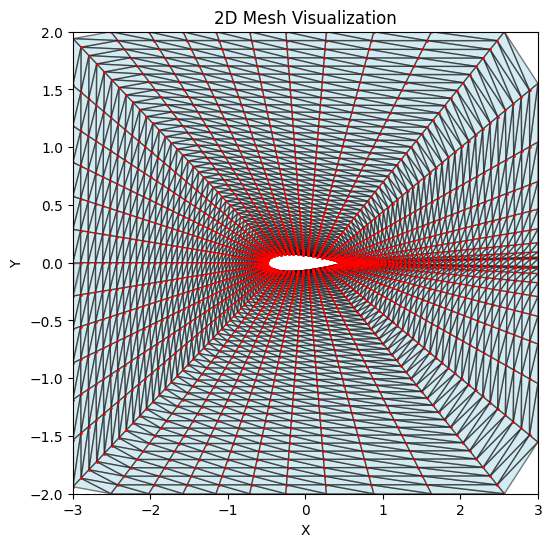

In [15]:
mesh = NACA_mesh(50,50,"0015", "triangle", angle_of_attack=0)
plot_mesh(mesh, "triangle")

In [16]:
meshio.write("NACAmesh.msh", mesh, file_format="gmsh22")